<a href="https://colab.research.google.com/github/julianovale/MCDA/blob/main/0009_DEA_Giovani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DEA

In [17]:
"""
Data Envelopment Analysis implementation
Sources:
Sherman & Zhu (2006) Service Productivity Management, Improving Service Performance using Data Envelopment Analysis (DEA) [Chapter 2]
ISBN: 978-0-387-33211-6
http://deazone.com/en/resources/tutorial
"""

# Execute esta célula para compilar a função dea(X,Y)
# Modelo CCR orientado a inputs

import numpy as np
from scipy.optimize import fmin_slsqp


class DEA(object):

    def __init__(self, inputs, outputs):
        """
        Initialize the DEA object with input data
        n = number of entities (observations)
        m = number of inputs (variables, features)
        r = number of outputs
        :param inputs: inputs, n x m numpy array
        :param outputs: outputs, n x r numpy array
        :return: self
        """

        # supplied data
        self.inputs = inputs
        self.outputs = outputs

        # parameters
        self.n = inputs.shape[0]
        self.m = inputs.shape[1]
        self.r = outputs.shape[1]

        # iterators
        self.unit_ = range(self.n)
        self.input_ = range(self.m)
        self.output_ = range(self.r)

        # result arrays
        self.output_w = np.zeros((self.r, 1), dtype=np.float)  # output weights
        self.input_w = np.zeros((self.m, 1), dtype=np.float)  # input weights
        self.lambdas = np.zeros((self.n, 1), dtype=np.float)  # unit efficiencies
        self.efficiency = np.zeros_like(self.lambdas)  # thetas

        # names
        self.names = []

    def __efficiency(self, unit):
        """
        Efficiency function with already computed weights
        :param unit: which unit to compute for
        :return: efficiency
        """

        # compute efficiency
        denominator = np.dot(self.inputs, self.input_w)
        numerator = np.dot(self.outputs, self.output_w)

        return (numerator/denominator)[unit]

    def __target(self, x, unit):
        """
        Theta target function for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: theta
        """
        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        denominator = np.dot(self.inputs[unit], in_w)
        numerator = np.dot(self.outputs[unit], out_w)

        return numerator/denominator

    def __constraints(self, x, unit):
        """
        Constraints for optimization for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: array of constraints
        """

        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        constr = []  # init the constraint array

        # for each input, lambdas with inputs
        for input in self.input_:
            t = self.__target(x, unit)
            lhs = np.dot(self.inputs[:, input], lambdas)
            cons = t*self.inputs[unit, input] - lhs
            constr.append(cons)

        # for each output, lambdas with outputs
        for output in self.output_:
            lhs = np.dot(self.outputs[:, output], lambdas)
            cons = lhs - self.outputs[unit, output]
            constr.append(cons)

        # for each unit
        for u in self.unit_:
            constr.append(lambdas[u])

        return np.array(constr)

    def __optimize(self):
        """
        Optimization of the DEA model
        Use: http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.linprog.html
        A = coefficients in the constraints
        b = rhs of constraints
        c = coefficients of the target function
        :return:
        """
        d0 = self.m + self.r + self.n
        # iterate over units
        for unit in self.unit_:
            # weights
            x0 = np.random.rand(d0) - 0.5
            x0 = fmin_slsqp(self.__target, x0, f_ieqcons=self.__constraints, args=(unit,))
            # unroll weights
            self.input_w, self.output_w, self.lambdas = x0[:self.m], x0[self.m:(self.m+self.r)], x0[(self.m+self.r):]
            self.efficiency[unit] = self.__efficiency(unit)

    def name_units(self, names):
        """
        Provide names for units for presentation purposes
        :param names: a list of names, equal in length to the number of units
        :return: nothing
        """

        assert(self.n == len(names))

        self.names = names

    def fit(self):
        """
        Optimize the dataset, generate basic table
        :return: table
        """

        self.__optimize()  # optimize

        print("Final thetas for each DMU:\n")
        print("---------------------------\n")
        for n, eff in enumerate(self.efficiency):
            if len(self.names) > 0:
                name = "DMU: %s" % self.names[n]
            else:
                name = "DMU: %d" % (n+1)
            print("%s theta: %.4f" % (name, eff))
            print("\n")
        print("---------------------------\n")

#### **Entrada**

In [18]:
# Entre com a matriz de Inputs
X = np.array([[14.2 , 32.44],
       [ 5.  ,  9.37],
       [14.3 ,  8.28],
       [12.9 , 38.64],
       [13.9 , 19.84],
       [ 5.  , 28.96],
       [ 8.5 , 25.09],
       [ 5.5 , 33.1 ],
       [10.  , 38.73],
       [13.5 , 36.67],
       [11.  , 14.17],
       [ 0.8 , 14.58]])

# Entre com a matriz de Inputs
Y = np.array(
      [[0.75,0.88,0.95], 
       [0.87,0.92,0.96],
       [0.77,0.94,0.97],
       [0.85,0.93,0.95],
       [0.99,0.91,0.99],
       [0.84,0.84,0.97],
       [0.69,0.88,0.95],
       [0.83,0.93,0.97],
       [0.84,0.82,0.95],
       [0.89,0.94,0.96],
       [0.58,0.85,0.99],
       [0.72,0.81,0.97]])

# Entre com os nomes das DMUs em forma de lista
names = ['Álvaro de Carvalho', 'Araraquara','Avaré','Baurú','Getulina','Iaras','Itaí', 'Lins', 'Marília', 'Pirajuí', 'Ribeirão Preto', 'Serra Azul']

In [19]:
#Crie o problema dea através do comando:
dea = DEA(X,Y)
#Inclua o nome das DMUs através do comando:
dea.name_units(names)

In [20]:
#Resolva os PLs e imprima os valores das eficiências:
dea.fit();

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3074222234962673
            Iterations: 12
            Function evaluations: 230
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0000000014296218
            Iterations: 10
            Function evaluations: 191
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0000000000018203
            Iterations: 11
            Function evaluations: 196
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.299366860900319
            Iterations: 10
            Function evaluations: 191
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5373022073376758
            Iterations: 8
            Funct

In [21]:
# Entre com a matriz de Inputs
X = np.array([[5,14],
       [8,15],
       [7,12]])

# Entre com a matriz de Inputs
Y = np.array(
      [[9,4,16], 
       [5,7,10],
       [4,9,13]])

# Entre com os nomes das DMUs em forma de lista
names = ['H1', 'H2', 'H3']

In [22]:
#Crie o problema dea através do comando:
dea = DEA(X,Y)
#Inclua o nome das DMUs através do comando:
dea.name_units(names)
#Resolva os PLs e imprima os valores das eficiências:
dea.fit();

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -74.43516516842962
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -88.15996078442085
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0000000023953282
            Iterations: 9
            Function evaluations: 90
            Gradient evaluations: 9
Final thetas for each DMU:

---------------------------

DMU: H1 theta: -74.4352


DMU: H2 theta: -88.1600


DMU: H3 theta: 1.0000


---------------------------



### Exercício - Telecomunicações

In [23]:
import pandas as pd

In [24]:
path = 'https://github.com/julianovale/MCDA/blob/main/dados/PL-DEA-ANATEL-Telecomunicacoes.xls?raw=true'
df = pd.read_excel(path, header=2, index_col=1)
df.drop('Unnamed: 0',inplace=True,axis=1)

In [25]:
df

,MN,P,AS,L,PT,AI
Telerj,66715,898157,3348768,13707,99951,3692804
Telemig,104585,650575,2746105,10947,73407,2895328
CTBC Telecom MG,17858,83923,362485,2373,7465,464154
Telest,25006,133454,50388,1837,1669,561042
Telebahia,93584,289541,1302615,4785,54439,1406159
Telergipe,8366,32158,159206,314,6776,170519
Telasa,6268,45267,227226,256,11681,25135
Telpe,33575,129859,714117,2821,41304,831171
Telpa,16296,51858,293823,686,13519,328803
Telern,13949,58218,294634,556,12607,329721


In [26]:
#Crie o problema dea através do comando:
dea = DEA(df[['L', 'PT', 'AI']].values, df[['MN', 'P', 'AS']].values)
#Inclua o nome das DMUs através do comando:
dea.name_units(df.index.values)
#Resolva os PLs e imprima os valores das eficiências:
dea.fit()
df['Efficiency'] = dea.efficiency
df['Lambda'] = dea.lambdas

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8196780878875926
            Iterations: 49
            Function evaluations: 2059
            Gradient evaluations: 49
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8033888703266945
            Iterations: 51
            Function evaluations: 2142
            Gradient evaluations: 51
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7691843102346436
            Iterations: 14
            Function evaluations: 588
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0000000007217709
            Iterations: 6
            Function evaluations: 252
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6986304539710775
            Iterations: 27
            Fun

In [27]:
df.loc[df['Efficiency'].values < 0.6]

,MN,P,AS,L,PT,AI,Efficiency,Lambda
Telpe,33575,129859,714117,2821,41304,831171,0.488782,5.278540e-16
Telebrasília,20617,19946,74912,3278,20175,884852,0.259848,-3.935381e-16
Teleacre,1815,11903,6833,313,2924,93604,0.393516,7.884181e-15


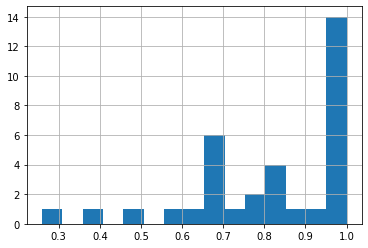

In [28]:
df.Efficiency.hist(bins=15)

In [29]:
df

,MN,P,AS,L,PT,AI,Efficiency,Lambda
Telerj,66715,898157,3348768,13707,99951,3692804,0.819678,2.825149e-15
Telemig,104585,650575,2746105,10947,73407,2895328,0.803389,1.023525e-15
CTBC Telecom MG,17858,83923,362485,2373,7465,464154,0.769184,6.120305e-15
Telest,25006,133454,50388,1837,1669,561042,1.000000,1.240576e+00
Telebahia,93584,289541,1302615,4785,54439,1406159,0.698630,6.924766e-16
Telergipe,8366,32158,159206,314,6776,170519,0.697865,-4.321795e-16
Telasa,6268,45267,227226,256,11681,25135,1.000000,1.031331e-15
Telpe,33575,129859,714117,2821,41304,831171,0.488782,5.278540e-16
Telpa,16296,51858,293823,686,13519,328803,0.662172,1.398357e-15
Telern,13949,58218,294634,556,12607,329721,0.680454,1.303920e-16
